# Project MedVision: Radiology AI Assistant Lab

Welcome back! In Notebook 01 you built a structured patient chart and crafted a handover note.
Today you will hand that context to our imaging AI engine and evaluate how well it assists the care team.

## Mission Brief

- Initialise the MedVision AI tooling inside Colab using the same self-contained setup pattern.
- Reuse the patient summary you assembled earlier to ground every imaging prompt.
- Experiment with prompts, personas, and images while logging clinical insights.
- Benchmark MedGemma against an experimental LLaVA engine and make a deployment recommendation.

### Why This Lab Matters: The Future of Diagnostic Collaboration

Radiology AI is already deployed in hospitals worldwide for:
- **Triage:** Flagging critical findings like pneumothorax for urgent reads
- **Quality assurance:** Catching missed findings on "normal" reports  
- **Workflow optimization:** Pre-populating draft reports for radiologist refinement

**Your generation will inherit these tools.** This lab teaches you to:
- Operate AI systems with clinical discipline
- Evaluate outputs with appropriate skepticism
- Communicate findings that blend AI insights with human judgment

**The Goal:** Not to replace radiologists, but to help them focus expertise where it matters most while maintaining safety standards you'd want for your own family.

### Learning Objectives

By the end of this lab, you will:
1. Understand how vision-language models "see" and "interpret" medical images
2. Craft effective prompts that ground AI analysis in clinical context
3. Recognize AI hallucinations and apply verification protocols
4. Evaluate competing AI models using clinical decision criteria
5. Integrate AI-assisted reads into safe clinical workflows

**Estimated time:** 90-120 minutes

### How to Use This Notebook
- Run cells from top to bottom; restart the runtime if you change dependencies.
- Challenge cells intentionally raise `NotImplementedError` until you complete them—this keeps the workflow honest.
- Solutions live in collapsed cells. Treat them as a safety net, not a shortcut.
- Keep the handover note from Notebook 01 close by; you will reference it throughout the lab.

## 0. Setup: Provision Your Colab Runtime

This cell clones (or updates) the MedVision repository, installs dependencies, and ensures the toolkit is importable.

### Backend Options

**Two configuration flags** control the AI engine:

1. **`USE_GGUF_BACKEND`** (default: `False`)
   - `True`: Use quantized GGUF model (4GB, fast inference)
   - `False`: Use full Transformers model (10GB, may OOM on free Colab)

2. **`ALLOW_CPU_FALLBACK`** (default: `False`) - **NEW**
   - `True`: Allow GGUF to run on CPU if GPU unavailable or CUDA build fails
   - `False`: Require GPU acceleration (15-20 minute build on first run)

### When to Enable CPU Fallback

Enable `ALLOW_CPU_FALLBACK = True` if:
- ✅ You don't have access to GPU-enabled Colab
- ✅ The CUDA build is failing repeatedly
- ✅ You want to test the notebook quickly (slower inference acceptable)
- ✅ You're using a CPU-only local environment

**Trade-off**: CPU inference takes ~1-2 minutes per image (vs 10-30 seconds on GPU)

### Recommended Configurations

| Scenario | `USE_GGUF_BACKEND` | `ALLOW_CPU_FALLBACK` | Result |
|----------|-------------------|---------------------|--------|
| **Free Colab (GPU)** | `True` | `False` | 15-20 min build, then fast inference |
| **Free Colab (CPU-only)** | `True` | `True` | 2-3 min setup, slow but working |
| **Free Colab (low RAM)** | `False` | N/A | May run out of memory |
| **Colab Pro (GPU)** | `True` | `False` | Best experience |
| **Local with GPU** | `True` | `False` | Fast local development |
| **Local CPU-only** | `True` | `True` | Usable for testing |

In [ ]:
from __future__ import annotations

import importlib
import importlib.util
import os
import subprocess
import sys
from importlib import metadata
from pathlib import Path
from typing import Final

from packaging.requirements import Requirement

REPO_URL: Final[str] = "https://github.com/BradSegal/OxfordADH2025PythonBootcamp.git"
CUDA_TORCH_INDEX: Final[str] = "https://download.pytorch.org/whl/cu121"
CUDA_TORCH_VERSION: Final[str] = "2.5.1"
LLAMA_CPP_VERSION: Final[str] = "0.2.90"
NUMPY_COMPAT_VERSION: Final[str] = "1.26.4"

# Configuration: Choose your backend
# "gguf" = Fast inference, requires 10-15 min build
# "transformers" = Fast setup, uses more RAM
USE_GGUF_BACKEND = False  # Set to True if you have time for the build

# CPU Fallback: Allow GGUF to run on CPU if GPU build fails or GPU unavailable
# Set to True to use smaller GGUF model on CPU-only instances (slower but works)
ALLOW_CPU_FALLBACK = False  # Set to True to enable CPU-only GGUF mode

workspace = Path.cwd()


def _reload_numpy():
    for module_name in [name for name in list(sys.modules) if name.startswith("numpy")]:
        sys.modules.pop(module_name, None)
    importlib.invalidate_caches()
    import numpy as np  # type: ignore
    return np


def _run_or_die(command: list[str]) -> None:
    completed = subprocess.run(command, capture_output=True, text=True)
    if completed.returncode != 0:
        print(completed.stdout)
        print(completed.stderr, file=sys.stderr)
        raise RuntimeError(f"Command failed: {' '.join(command)}")


def _colab_has_gpu() -> bool:
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    except FileNotFoundError:
        return False
    return result.returncode == 0


def _llama_cpp_has_cuda_extension() -> bool:
    try:
        return importlib.util.find_spec("llama_cpp.llama_cpp_cuda") is not None
    except ModuleNotFoundError:
        return False


def _ensure_llama_cpp_cuda() -> None:
    """
    Install llama-cpp-python with CUDA support.
    
    This requires building from source which takes 15-20 minutes.
    """
    
    # Quick check: already working?
    if _llama_cpp_has_cuda_extension():
        try:
            version = metadata.version("llama-cpp-python")
            print(f"  ✓ llama-cpp-python {version} with CUDA already installed")
            return
        except:
            pass
    
    print("  🔨 Building llama-cpp-python with CUDA support...")
    print("  ⏱️  This takes 15-20 minutes (building CUDA kernels)")
    print("  📊 Build will show progress below...")
    print("  ✅ Future runs will skip this (cached for session)")
    print("")
    
    env = os.environ.copy()
    env['CMAKE_ARGS'] = '-DGGML_CUDA=on -DCMAKE_CUDA_ARCHITECTURES=all-major'
    env['FORCE_CMAKE'] = '1'
    
    try:
        # Removed timeout - let it run as long as needed
        subprocess.run([
            sys.executable, "-m", "pip", "install",
            f"llama-cpp-python=={LLAMA_CPP_VERSION}",
            "--no-cache-dir", "--force-reinstall", "--verbose"
        ], env=env, check=True)  # No timeout parameter
        
        # Clear import cache
        for module_name in [m for m in list(sys.modules) if m.startswith("llama_cpp")]:
            sys.modules.pop(module_name, None)
        importlib.invalidate_caches()
        
        if _llama_cpp_has_cuda_extension():
            print("\n  ✅ Build complete! GPU acceleration ready.")
            print("  🎉 Setup complete - continue to next cell")
            return
        
        raise RuntimeError("Build completed but CUDA extension not detected")
        
    except Exception as e:
        print(f"\n  ❌ Build failed: {e}")
        if ALLOW_CPU_FALLBACK:
            print("\n💡 CPU fallback enabled - will use CPU-only llama-cpp-python")
            print("   ⚠️  Note: CPU inference will be slower (1-2 minutes per image)")
        else:
            print("\n💡 Alternative: Use transformers backend (faster setup)")
            print("   Set USE_GGUF_BACKEND = False at the top of this cell")
            print("   OR set ALLOW_CPU_FALLBACK = True to use GGUF on CPU")
            raise


def _ensure_numpy_compatibility() -> None:
    try:
        import numpy as np  # type: ignore
        if not np.__version__.startswith("2."):
            return  # Already compatible
    except ImportError:
        pass
    
    # Need to install or downgrade numpy
    print(f"  Installing numpy {NUMPY_COMPAT_VERSION}…")
    _run_or_die([
        sys.executable, "-m", "pip", "install",
        "--quiet", "--upgrade", f"numpy=={NUMPY_COMPAT_VERSION}"
    ])
    _reload_numpy()


# ============================================================================
# Main Setup
# ============================================================================

print("=" * 70)
print("PROJECT MEDVISION - SETUP")
print("=" * 70)

if USE_GGUF_BACKEND:
    print("Backend: GGUF (quantized model)")
    if ALLOW_CPU_FALLBACK:
        print("⏱️  Setup time: 2-3 minutes (CPU fallback enabled)")
        print("⚡ Inference: Slower on CPU (~5-8 minutes per image)")
    else:
        print("⏱️  Setup time: 15-20 minutes (one-time CUDA build)")
        print("⚡ Inference: Fast (~1-2 minutes per image)")
    print("💾 RAM usage: Low (~4GB model)")
else:
    print("Backend: Transformers (full model)")
    print("⏱️  Setup time: 2-3 minutes (download model)")
    print("⚡ Inference: Fast (~10-30 seconds per image)")
    print("💾 RAM usage: High (~10GB model)")
    print("⚠️  Note: May run out of memory on free Colab")

print("=" * 70)
print()

# 1. Clone or update repository
if (workspace / "src" / "medvision_toolkit").exists():
    repo_root = workspace
    print("✓ Detected Project MedVision source in workspace.")
elif (workspace.parent / "src" / "medvision_toolkit").exists():
    repo_root = workspace.parent
    print(f"✓ Detected Project MedVision in parent: {repo_root}")
else:
    repo_root = workspace / "python-for-medicine-bootcamp"
    if repo_root.exists():
        print("Pulling latest changes…")
        _run_or_die(["git", "-C", str(repo_root), "pull", "--ff-only"])
    else:
        print(f"Cloning from {REPO_URL}…")
        _run_or_die(["git", "clone", "--depth", "1", REPO_URL, str(repo_root)])

requirements_path = repo_root / "requirements.txt"
if not requirements_path.exists():
    raise FileNotFoundError(f"requirements.txt not found at {requirements_path}")

# 2. Detect environment
try:
    import google.colab  # type: ignore  # noqa: F401
    in_colab = True
    os.environ["MEDVISION_IN_COLAB"] = "1"
    has_gpu = _colab_has_gpu()
    if has_gpu and not ALLOW_CPU_FALLBACK:
        os.environ["MEDVISION_EXPECTS_GPU"] = "1"
except ImportError:
    in_colab = False
    has_gpu = False

if in_colab:
    # 3. Install core dependencies
    print("Installing core dependencies…")
    core_packages = [
        "transformers>=4.40.0",
        "accelerate",
        "pillow",
        "requests",
        "matplotlib",
        "ipykernel",
        "ipywidgets"
    ]
    
    for package in core_packages:
        try:
            req = Requirement(package)
            name = req.name
            installed = metadata.version(name)
            if not req.specifier or req.specifier.contains(installed, prereleases=True):
                print(f"  ✓ {name} {installed} already installed")
                continue
        except metadata.PackageNotFoundError:
            pass
        
        print(f"  Installing {package}…")
        _run_or_die([sys.executable, "-m", "pip", "install", "--quiet", package])
    
    # 4. Ensure numpy compatibility (BEFORE heavy packages)
    print("Ensuring numpy compatibility…")
    _ensure_numpy_compatibility()
    
    # 5. Install PyTorch with CUDA
    if has_gpu:
        print("Checking PyTorch CUDA support…")
        try:
            import torch  # type: ignore
            if torch.cuda.is_available():
                print(f"  ✓ torch {torch.__version__} with CUDA already installed")
            else:
                raise ImportError("torch installed but no CUDA")
        except ImportError:
            print(f"  Installing torch {CUDA_TORCH_VERSION} with CUDA…")
            _run_or_die([
                sys.executable, "-m", "pip", "install", "--quiet",
                f"torch=={CUDA_TORCH_VERSION}",
                "--index-url", CUDA_TORCH_INDEX
            ])
        
        # 6. Install llama-cpp-python with CUDA (ONLY if GGUF backend chosen)
        if USE_GGUF_BACKEND:
            if ALLOW_CPU_FALLBACK:
                print("\n⚠️  CPU fallback enabled - installing CPU-only llama-cpp-python")
                print("   (Skipping 15-20 minute CUDA build)")
                try:
                    import llama_cpp  # type: ignore
                    print(f"  ✓ llama-cpp-python already installed")
                except ImportError:
                    _run_or_die([
                        sys.executable, "-m", "pip", "install", "--quiet",
                        f"llama-cpp-python=={LLAMA_CPP_VERSION}"
                    ])
            else:
                print("\nInstalling llama-cpp-python with CUDA…")
                print("(This is the slow part - see time estimate above)")
                _ensure_llama_cpp_cuda()
        else:
            print("\n✓ Skipping llama-cpp-python (using transformers backend)")
    
    else:
        # CPU-only installation
        print("Installing CPU-only packages…")
        try:
            import torch  # type: ignore
            print(f"  ✓ torch {torch.__version__} already installed")
        except ImportError:
            _run_or_die([
                sys.executable, "-m", "pip", "install", "--quiet",
                f"torch=={CUDA_TORCH_VERSION}"
            ])
        
        if USE_GGUF_BACKEND:
            try:
                import llama_cpp  # type: ignore
                print(f"  ✓ llama-cpp-python already installed")
            except ImportError:
                _run_or_die([
                    sys.executable, "-m", "pip", "install", "--quiet",
                    f"llama-cpp-python=={LLAMA_CPP_VERSION}"
                ])

else:
    print("Running locally. Assuming dependencies installed.")
    print("If errors occur: pip install -r requirements.txt")

# 7. Add project to Python path
project_src = repo_root / "src"
if str(project_src) not in sys.path:
    sys.path.insert(0, str(project_src))
    print(f"✓ Added {project_src} to Python path")

print("\n" + "=" * 70)
print("✅ SETUP COMPLETE")
print("=" * 70)
if USE_GGUF_BACKEND:
    print("Backend: GGUF (quantized, fast inference)")
    if ALLOW_CPU_FALLBACK:
        print("⚠️  CPU fallback mode: Inference will be slower but works without GPU")
else:
    print("Backend: Transformers (full model)")
    print("⚠️  Initialize with: initialize_medgemma_engine(backend='transformers')")
print("\nContinue to the next cell →")
print("=" * 70)

In [ ]:
from __future__ import annotations
import os
import torch
from medvision_toolkit import llama_cpp_has_cuda_support

expects_gpu = os.environ.get("MEDVISION_EXPECTS_GPU") == "1"

print(f"torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"Active GPU: {device_name}")

if expects_gpu and not torch.cuda.is_available():
    raise RuntimeError(
        "A Colab GPU runtime is required. Go to Runtime → Change runtime type → GPU, then rerun the setup cell."
    )

llama_has_cuda = llama_cpp_has_cuda_support()
print(f"llama.cpp CUDA support: {llama_has_cuda}")

if expects_gpu and not llama_has_cuda:
    if ALLOW_CPU_FALLBACK:
        print("⚠️  WARNING: GPU detected but llama.cpp will run on CPU (ALLOW_CPU_FALLBACK=True)")
        print("   Inference will be slower (~5-8 minutes per image instead of 1-2 minutes)")
        print("   For faster inference: Set ALLOW_CPU_FALLBACK=False and rerun setup to build CUDA support")
    else:
        raise RuntimeError(
            "llama-cpp-python was installed without CUDA support. Rerun the setup cell to install the CUDA wheel."
        )

### Quick Systems Check

Confirm the toolkit loads, summarise the patient profile, and preview tonight's handover so the AI work stays grounded in clinical reality.

In [3]:
from medvision_toolkit import (
    draft_handover_for_night_team,
    load_sample_patient,
    summarize_patient,
    summarize_patient_for_imaging,
)

patient_profile = load_sample_patient()
print(summarize_patient(patient_profile))

handover_note = draft_handover_for_night_team(patient_profile)
print("\nNight Handover Preview:\n")
print(handover_note)

imaging_snapshot = summarize_patient_for_imaging(patient_profile)
print("\nConcise imaging snapshot (<=200 chars):\n")
print(imaging_snapshot)
print(f"\nSnapshot length: {len(imaging_snapshot)} characters")


Jordan Nguyen (MRN MV-102938), 54 y/o, primary diagnosis: Community-acquired pneumonia with sepsis. Latest systolic BP: 129 mmHg, pain score: 2/10. 2 outstanding task(s) for the team.

Night Handover Preview:

Handover for Jordan Nguyen (MRN MV-102938)
Attending: Dr. Priya Patel | Primary Dx: Community-acquired pneumonia with sepsis

Vitals Snapshot:
- Latest systolic BP: 129 mmHg; range 129-146 mmHg
- Pain trend: peak 7/10, current 2/10

Scheduled Medications:
- Metformin 1000 mg PO BID
- Lisinopril 10 mg PO daily
- Atorvastatin 20 mg PO nightly

PRN Medications:
- Oxycodone 5 mg PO q4h PRN pain > 6
- Ondansetron 4 mg PO PRN nausea

Action Items for Next Shift:
- Follow-up blood cultures
- Reassess oxygen requirement during ambulation

Concise imaging snapshot (<=200 chars):

Jordan Nguyen (54 y/o); Community-acquired pneumonia with sepsis; BP 129 mmHg, HR 76 bpm, pain 2/10; Tasks: Follow-up blood cultures…

Snapshot length: 133 characters


### Prompt Fuel: Keep it Tight

Copy the **Concise imaging snapshot** above into your prompts when needed. It is already trimmed to stay under 200 characters, so the vision-language model can devote tokens to the question and findings instead of repeating the entire handover note.

## 0.5. Before We Start: Understanding Medical AI

Before you interact with the RadiologyAI engine, you need to understand what you're working with—and more importantly, what its limitations are.

### Vision-Language Models: The Technology Behind the Assistant

The RadiologyAI engine you're about to use is a **vision-language model (VLM)**—an AI system trained to:

1. **"See"** patterns in images (like infiltrates, device placement, cardiac silhouettes)
2. **"Understand"** your clinical questions in natural language  
3. **"Respond"** with structured text findings

**Key Insight:** Unlike rule-based systems or clinical decision tools, VLMs use **statistical pattern recognition**. They don't "know" medicine in the way a radiologist does—they've learned associations from analyzing millions of images and text pairs during training.

Think of it like this:
- A radiologist **understands** that hazy opacities in a certain distribution suggest pulmonary edema because they know cardiac physiology
- A VLM has **learned** that images with those visual patterns are often described using words like "pulmonary edema" in radiology reports

The VLM can be remarkably helpful, but it's pattern-matching, not reasoning.

### What is GGUF? Why Does It Matter in Colab?

You'll see references to "GGUF" throughout this lab. Here's what you need to know:

- **GGUF** = A quantized model format that trades some numerical precision for much smaller file sizes
- **Full MedGemma model:** ~10GB (won't fit in free Colab's memory)
- **GGUF quantized version:** ~4GB (perfect for teaching environments)
- **The trade-off:** Slightly less nuanced outputs, but 95% as capable for learning purposes

**Why this matters:** Quantization makes cutting-edge AI accessible for education and prototyping. In production radiology departments, you'd typically use the full-precision model on dedicated GPU servers.

### The Three Pillars of Safe AI-Assisted Radiology

⚠️ **CRITICAL SAFETY PRINCIPLES**

Every AI-generated finding in this lab is **preliminary** and requires:

1. **Verification:** A qualified radiologist must review the source images and confirm or revise AI-suggested findings
2. **Clinical Correlation:** AI outputs must be interpreted in the context of patient history, physical exam, labs, and prior imaging
3. **Documentation:** Any clinical decision informed by AI must document that AI was used as a decision support tool

**In Real Practice:** You would never act on an AI read alone. Think of the AI as a smart intern's draft report—useful for catching things you might have missed, but you always verify their work before signing off.

**Scope of Practice:** As medical students and junior doctors, you are learning to consume AI outputs critically. Interpreting imaging studies and making diagnostic conclusions remains the domain of qualified radiologists and supervising physicians.

### Common AI Failure Modes You'll Encounter

**1. Hallucinations:** The AI confidently reports findings that aren't actually present in the image

**2. Overconfidence:** Stating definitive diagnoses when findings are subtle or ambiguous  

**3. Measurement Errors:** Quantifying things (angles, volumes, dimensions) without actual measurement tools

**4. Context Blindness:** Missing clinically relevant details because the prompt didn't explicitly ask about them

**5. Rare Finding Struggles:** Performing poorly on uncommon pathologies not well-represented in training data

You'll practice detecting these failure modes throughout the lab.

### Reflection Question (Think Before Moving On)

**Scenario:** An overnight AI system flags a chest X-ray as "likely normal" and deprioritizes it in the reading queue. The next morning, a radiologist reviews it and identifies a small pneumothorax that the AI missed.

Who is responsible? What safeguards should be in place?

*There's no single right answer, but thinking through this now will make you a better steward of these tools.*

---

**Now that you understand what you're working with—and what could go wrong—let's begin the lab with clear eyes.**

## 1. Onboarding: Spin Up the Radiology Engine

We abstracted the heavy lifting into helper functions. Initialising the engine should feel like calling a standard protocol.

In [4]:
from medvision_toolkit import (
    build_radiology_prompt,
    initialize_medgemma_engine,
    load_and_display_image,
    stream_ai_report
)

print("--- Initialising MedGemma Engine ---")
medgemma_engine = initialize_medgemma_engine(backend="transformers" if not USE_GGUF_BACKEND else "gguf")
print(f"Images are automatically resized to {medgemma_engine.max_image_edge}px on the longest edge.")

--- Initialising MedGemma Engine ---


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using `use_fast=True` but `torchvision` is not available. Falling back to the slow image processor.


Images are automatically resized to 256px on the longest edge.


### What Happens During Initialization?

When you run the next cell, the toolkit will execute several steps behind the scenes:

**Step 1: Model Download** (~3-5 minutes on first run)
- The GGUF-quantized MedGemma model (~4GB) downloads from Hugging Face Hub
- Subsequent runs are instant—the model is cached in Colab's storage
- If you restart the runtime, the cache persists for this session

**Step 2: Model Loading** (~30 seconds)
- The model loads into Colab's RAM (~10GB total memory required)
- The inference engine compiles optimizations for your hardware
- A warmup inference runs to ensure everything works

**Step 3: Validation** (~5 seconds)
- The toolkit runs a quick test to confirm the model can generate text
- If successful, you'll see "Engine initialized" confirmation

**⏱️ Total Expected Time:**
- First run: 5-10 minutes (mostly download time)
- Subsequent runs: 30-45 seconds (loading only)

**💾 Colab Resource Check:**

Free Colab provides:
- **RAM:** 12-13GB (we need ~10GB for MedGemma)
- **Disk:** 100GB+ (plenty for our 8GB model)
- **Session duration:** 12 hours max, 90 minutes idle timeout

**🚨 Troubleshooting Common Issues:**

| Problem | Likely Cause | Solution |
|---------|-------------|----------|
| "Out of memory" error | Other notebooks consuming RAM | Runtime → Manage sessions → Terminate others |
| Download stalls at 99% | Network timeout | Restart runtime, rerun setup cell |
| "Model not found" error | Hugging Face access issue | Check you're online; try again in 1-2 minutes |
| Slow inference (>2 min/image) | CPU-only mode (no GPU allocated) | Runtime → Change runtime type → T4 GPU (if available) |

**💡 Pro Tip:** If you're repeatedly restarting the runtime during experimentation, the model download is cached. You only pay the download cost once per Colab session.

## 2. Golden Path: First Assisted Read

We'll analyse a sample chest X-ray while explicitly threading in the patient context you curated earlier.

1️⃣ Displaying imaging study:


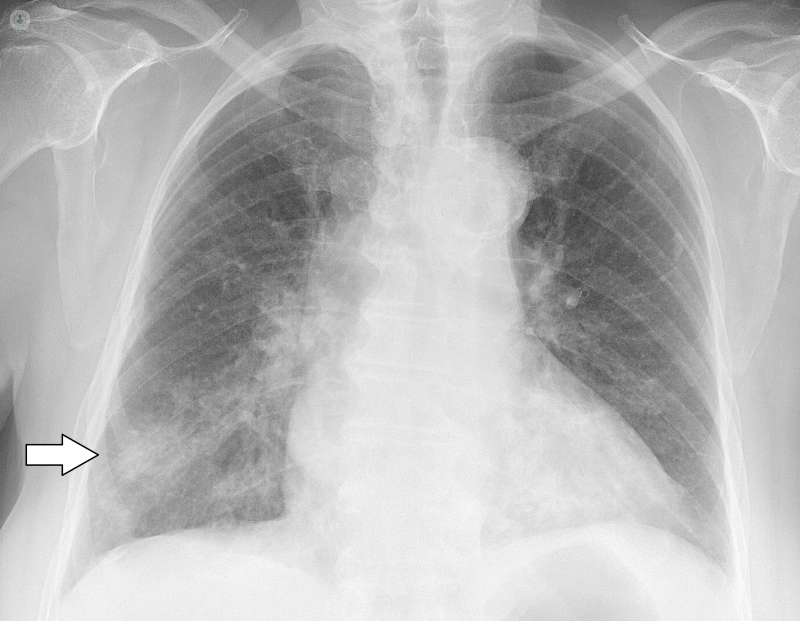

2️⃣ Prompt sent to MedGemma:
You are acting as a radiologist. 
Patient context: Jordan Nguyen (54 y/o); Community-acquired pneumonia with sepsis; BP 129 mmHg, HR 76 bpm, pain 2/10; Tasks: Follow-up blood cultures….
Clinical focus today: Monitor pneumonia resolution and cardiac workload.

Describe acute and chronic findings relevant to this patient's recovery plan.
Prompt length: 337 characters
--- AI PRELIMINARY REPORT ---


Okay, I've reviewed the chest X-ray provided. Here's a radiologist's perspective on the acute and chronic findings relevant to Jordan Nguyen's recovery, given his clinical context:

**Acute Findings (Relevant to Current Status):**

*   **Right Lower Lobe Infiltrate (White Arrow):** This is the most prominent finding. It indicates consolidation in the right lower lobe of the lung, which is highly suggestive of pneumonia. The location and appearance (although not fully detailed in this image) would help further characterize the pneumonia (e.g., lobar vs. bronchopneumonia).
*   **Cardiomegaly:** The heart appears enlarged. This could be due to a variety of factors, including:
    *   **Cardiomyopathy:** Weakening of the heart muscle.
    *   **Hypertension:** Chronic high blood pressure can lead to left ventricular hypertrophy and cardiomegaly.
    *   **Fluid Overload:** Sepsis can cause fluid retention, which can increase cardiac workload and size.
    *   **Congestive Heart Failure:** If the patient has underlying heart failure, the cardiomegaly could be a result of the condition.
*   **Pulmonary Vascular Congestion:** This is often seen in patients with sepsis and/or heart failure. It appears as increased interstitial markings and peribronchial cuffing.

**Chronic Findings (Relevant to Long-Term Management):**

*   **Cardiomegaly:** As mentioned above, cardiomegaly can be a chronic finding, especially if it's related to hypertension or cardiomyopathy. This needs to be monitored over time.
*   **Possible Pulmonary Hypertension:** The increased pulmonary vascular markings could indicate pulmonary hypertension, which can be a consequence of chronic lung disease or other underlying conditions. This would need to be assessed with further imaging (e.g., echocardiogram) if the pneumonia resolves and the patient remains symptomatic.

**Interpretation and Implications for Management:**

The presence of a right lower lobe infiltrate, cardiomegaly, and pulmonary vascular congestion suggests that Jordan Nguyen is currently dealing with pneumonia and potentially some degree of cardiac stress. The cardiomegaly could be a chronic condition, or it could be exacerbated by the acute illness and sepsis.

The key goals in managing this patient are:

1.  **Monitor Pneumonia Resolution:** The chest X-ray will be followed up to ensure the infiltrate is clearing and there are no new areas of consolidation.
2.  **Manage Sepsis:** Continue to address the underlying cause of the sepsis and provide supportive care.
3.  **Assess Cardiac Function:** An echocardiogram may be necessary to evaluate the heart's structure and function, especially if the cardiomegaly is significant or if the patient develops new heart failure symptoms.
4.  **Address Underlying Risk Factors:** If the patient has risk factors for heart disease (e.g., hypertension, diabetes, hyperlipidemia), these should be aggressively managed.
5.  **Monitor for Complications:** Watch for complications of pneumonia (e.g., empyema, lung abscess) and sepsis (e.g., acute respiratory distress syndrome, multi-organ failure).

**In summary, this chest X-ray shows evidence of pneumonia and possible cardiac stress. Close monitoring and appropriate management are crucial to ensure Jordan Nguyen's recovery.**

**Disclaimer:** This interpretation is based solely on the provided chest X-ray and clinical context. A complete evaluation requires a thorough clinical history, physical examination, and potentially additional imaging or laboratory tests. This information should not be used as a substitute for professional medical advice.

In [5]:
sample_image_url = "https://staticnew-prod.topdoctors.co.uk/files/Image/large/5ad0cd79-11d0-47b7-840b-123525bbab96.jpg"
clinical_focus = "Monitor pneumonia resolution and cardiac workload"
question = "Describe acute and chronic findings relevant to this patient's recovery plan."
persona = "radiologist"

print("1️⃣ Displaying imaging study:")
load_and_display_image(sample_image_url)

prompt = build_radiology_prompt(
    profile=patient_profile,
    clinical_focus=clinical_focus,
    question=question,
    persona=persona,
)
print("2️⃣ Prompt sent to MedGemma:")
print(prompt)
print(f"Prompt length: {len(prompt)} characters")

print("--- AI PRELIMINARY REPORT ---")
report = stream_ai_report(
    engine=medgemma_engine,
    image_path_or_url=sample_image_url,
    prompt=prompt,
    persona=persona,
)

Take a moment to compare the AI's commentary with your handover note. Where do they agree? Where should a clinician remain sceptical?

In [6]:
report

"Okay, I've reviewed the chest X-ray provided. Here's a radiologist's perspective on the acute and chronic findings relevant to Jordan Nguyen's recovery, given his clinical context:\n\n**Acute Findings (Relevant to Current Status):**\n\n*   **Right Lower Lobe Infiltrate (White Arrow):** This is the most prominent finding. It indicates consolidation in the right lower lobe of the lung, which is highly suggestive of pneumonia. The location and appearance (although not fully detailed in this image) would help further characterize the pneumonia (e.g., lobar vs. bronchopneumonia).\n*   **Cardiomegaly:** The heart appears enlarged. This could be due to a variety of factors, including:\n    *   **Cardiomyopathy:** Weakening of the heart muscle.\n    *   **Hypertension:** Chronic high blood pressure can lead to left ventricular hypertrophy and cardiomegaly.\n    *   **Fluid Overload:** Sepsis can cause fluid retention, which can increase cardiac workload and size.\n    *   **Congestive Heart F

### 🔍 Critical Skill: Recognizing AI Hallucinations

Now that you've seen your first AI-generated report, let's practice the most important safety skill: **detecting hallucinations and overconfident statements**.

**What is a Hallucination?**

In AI systems, a **hallucination** occurs when the model generates plausible-sounding content that isn't supported by the input data. In medical imaging, this means reporting findings that aren't actually visible in the image.

**Common Hallucination Patterns in Radiology AI:**

| Pattern | Example | Why It Happens |
|---------|---------|----------------|
| **Fabricated devices** | "ET tube tip at the carina" when no tube is present | Training data heavily featured intubated patients |
| **Phantom pathology** | "Small left pleural effusion" on a normal film | Model associates clinical context with findings |
| **Precise measurements** | "Cardiac silhouette measures 14.2cm" | Model generates numbers without actual measurement |
| **Definitive diagnoses** | "Pneumonia confirmed" vs "Opacity concerning for pneumonia" | Overconfident language from training data |
| **Temporal assumptions** | "New infiltrate since prior study" when no prior was provided | Model fabricates comparison context |

**🧪 Quick Exercise: Audit the Report Above**

Review the AI-generated report from Section 2. For each statement, classify it as:

- ✅ **Descriptive observation** (safe): "The cardiac silhouette appears enlarged"
- ⚠️ **Interpretive finding** (verify): "Findings consistent with pulmonary edema"  
- 🚨 **Definitive diagnosis** (escalate): "Patient has congestive heart failure"
- ❓ **Unprovable claim** (hallucination risk): "ETT tip is 3cm above the carina" (if no ETT visible)

**Which statements would you flag for radiologist verification?**

## 3. Interactive Lab: Prompt Crafting & Personas

You now control the imaging consult. Experiment with different focuses, questions, and personas while keeping track of what helps—or confuses—the AI.

---

### 🎓 What You've Learned So Far

**Section 1-2 Recap:**
- ✅ Initialized a medical vision-language model in Colab
- ✅ Ran your first AI-assisted imaging analysis
- ✅ Learned to recognize hallucinations and verification requirements

**Next:** Now you'll take control. In Section 3, you'll craft your own prompts, experiment with different personas, and discover what makes AI output clinically useful vs unreliable.

**Estimated time for Section 3:** 30-40 minutes

---

### Challenge 3.1: Structured Prompt Engineering

**Clinical Scenario:**

Jordan's care team administered 3 liters of IV fluids during sepsis resuscitation. It's now Day 3, and the team is concerned about **fluid overload**. They need the AI to focus specifically on signs of pulmonary vascular congestion and pleural effusions.

**Your Task:**

Craft a new prompt that:
1. Directs the AI's attention to **fluid status** (not general findings)
2. Asks for **actionable observations** that inform diuresis decisions
3. Maintains clinical context from Jordan's handover note

**📋 Good Medical Prompt Checklist:**

Before you write your prompt, review these principles:

- ✅ **Specific clinical question** (not "describe everything")
  - Good: "Assess for pulmonary edema and pleural effusions"
  - Poor: "Look at the chest X-ray"

- ✅ **Relevant patient context** (from the handover note)
  - Include: Recent fluid balance, current symptoms, treatment course
  - Avoid: Irrelevant biographical details

- ✅ **Requests structured output**
  - Ask for: Findings → Impression → Recommendations
  - Avoid: Open-ended "tell me what you see"

- ✅ **Appropriate scope**
  - Good: "Describe findings concerning for volume overload"
  - Poor: "Should we give furosemide?" (asks AI to prescribe)

**💡 Example Comparison:**

| Aspect | ❌ Weak Prompt | ✅ Strong Prompt |
|--------|--------------|-----------------|
| **Focus** | "Analyze this chest X-ray" | "Assess for pulmonary vascular congestion in a patient with +3L fluid balance" |
| **Context** | None provided | "Post-sepsis resuscitation, currently euvolemic per exam" |
| **Output** | Unstructured | "Provide findings, impression, and suggest follow-up imaging if needed" |
| **Scope** | "What should I do?" | "Describe radiographic findings that inform diuresis decisions" |

**🎯 Success Criteria:**

Your prompt should produce a report that:
- ✅ Mentions specific findings related to fluid status (vascular markings, effusions, Kerley B lines)
- ✅ Connects observations back to the clinical question
- ✅ Uses appropriate hedging language ("suggestive of", "may represent") for ambiguous findings
- ✅ Flags uncertainties rather than guessing
- ❌ Does NOT fabricate devices or measurements
- ❌ Does NOT make treatment decisions

**Now update the variables below and run the analysis:**

> ℹ️ **Token Discipline:** Aim for prompts under 400 characters. Reuse the concise imaging snapshot instead of pasting the full handover.

In [ ]:
# TODO: Update these variables with your fluid-focused prompt
experiment_focus = "Update this to focus on fluid overload assessment"
experiment_question = "Update this to ask for specific findings related to volume status"
experiment_persona = "radiologist"

# Build and display the prompt
prompt = build_radiology_prompt(
    profile=patient_profile,
    clinical_focus=experiment_focus,
    question=experiment_question,
    persona=experiment_persona,
)
print("=== YOUR PROMPT ===")
print(prompt)
print(f"Prompt length: {len(prompt)} characters")
print("\n")

# TODO: Remove the NotImplementedError and uncomment the code below when ready
raise NotImplementedError("Challenge 3.1: Update the variables above, then remove this line and run the analysis.")

# Uncomment these lines after updating the prompt variables:
# print("=== AI REPORT ===")
# experiment_report = stream_ai_report(
#     engine=medgemma_engine,
#     image_path_or_url=sample_image_url,
#     prompt=prompt,
#     persona=experiment_persona,
# )
#
# print("\n🧪 Self-Assessment: Review the success criteria above.")
# print("Did your prompt produce findings focused on fluid status?")
# print("Did the AI use appropriate hedging language?")


### 📝 Prompt Lab Log
Record your trials here. What wording produced the clearest guidance?

In [ ]:
prompt_lab_notes = '''
# Prompt Experimentation Log

**Instructions:** After each experiment (Challenges 3.1-3.3), record what you learned.

| Experiment | Focus | Persona | Useful Takeaways | Cautions |
|------------|-------|---------|------------------|----------|
| **Example** | Assess cardiac silhouette size and pulmonary vasculature | Cardiologist | AI flagged possible cardiomegaly with CTR reference; mentioned pulmonary vascular redistribution | AI estimated CTR without actual measurement tools—would need manual verification before reporting |
| **Challenge 3.1** | <Your fluid overload focus> | <Your persona> | <What worked well?> | <What to verify or be skeptical about?> |
| **Challenge 3.2** | <Your cardiology focus> | <Your persona> | <What changed with the new persona?> | <Any hallucinations or overconfidence?> |
| **Challenge 3.3** | <Your custom image focus> | <Your persona> | <How did different image quality affect output?> | <Any misidentification of modality or view?> |

---

## Key Insights from Your Experiments

**What makes a prompt effective?**
- (Record your observations here after completing the challenges)

**Which persona produced the most clinically useful output for Jordan's case?**
- (Your answer here)

**What findings did you consistently need to verify across all AI reports?**
- (Common hallucination patterns you noticed)

**If you were deploying this AI in a real radiology department, what safeguards would you require?**
- (Your recommendations based on what you learned)

---

💡 **Pro Tip:** Save this log! These insights transfer to other clinical AI tools you'll encounter in practice.
'''
print(prompt_lab_notes)

### Challenge 3.2: Persona Shifting & Priority Framing

**The Power of Persona:**

When you assign a "persona" to the AI, you're essentially asking it to emphasize the priorities and vocabulary of that specialty. Different specialists look at the same image through different clinical lenses.

**How Personas Affect AI Output:**

| Persona | Primary Focus | Typical Language | Common Priorities |
|---------|--------------|------------------|-------------------|
| **Radiologist** | Anatomical findings, differential diagnoses | "Opacity," "consolidation," "silhouette sign" | Comprehensive description, DDx |
| **Cardiologist** | Cardiac silhouette, pulmonary vasculature | "Cardiomegaly," "vascular redistribution" | Heart size, fluid status, device position |
| **Intensivist** | Life-threatening findings, device placement | "Emergent," "critical," "requires immediate" | Pneumothorax, line placement, ARDS |
| **Pulmonologist** | Parenchymal disease, airways | "Infiltrate," "bronchiectasis," "hyperinflation" | Infection, COPD, ILD patterns |

**Clinical Scenario:**

The cardiology team is now rounding on Jordan. They're less concerned with pneumonia resolution (that's improving) and more focused on:
- **Cardiac silhouette size** (concerned about cardiomegaly)
- **Pulmonary vascular markings** (fluid status)
- **Any signs of heart failure** that might complicate sepsis recovery

**Your Task:**

1. Update the persona to `"cardiologist"`
2. Craft a focus statement that prioritizes cardiac concerns
3. Ask a question that a cardiologist would care about (not a general radiologist)

**🎯 Success Criteria:**

The AI report should:
- ✅ Emphasize cardiac findings over pulmonary details
- ✅ Use cardiology-specific terminology (CTR, vascular redistribution, etc.)
- ✅ Comment on findings relevant to heart failure assessment
- ✅ De-emphasize or briefly mention pneumonia (that's pulmonology's domain)

**💡 Pro Tip:**

The best clinical prompts match the AI persona to the actual consult question. If cardiology is consulting for "rule out cardiomegaly," use the cardiologist persona and frame the question accordingly.

> ℹ️ Keep the persona prompt tight—reuse the imaging snapshot and keep custom text short.

In [ ]:
# TODO: Update these variables with a cardiology-focused prompt
persona_focus = "Update with cardiac-specific concerns (cardiac size, heart failure signs)"
persona_question = "Update with a question a cardiologist would ask"
persona_label = "cardiologist"

# Build and display the prompt
prompt = build_radiology_prompt(
    profile=patient_profile,
    clinical_focus=persona_focus,
    question=persona_question,
    persona=persona_label,
)
print("=== CARDIOLOGY-FOCUSED PROMPT ===")
print(prompt)
print(f"Prompt length: {len(prompt)} characters")
print("\n")

# TODO: Remove the NotImplementedError and uncomment the code below when ready
raise NotImplementedError("Challenge 3.2: Update the variables above, then remove this line and run the analysis.")

# Uncomment these lines after updating the prompt variables:
# print("=== CARDIOLOGY-FOCUSED REPORT ===")
# persona_report = stream_ai_report(
#     engine=medgemma_engine,
#     image_path_or_url=sample_image_url,
#     prompt=prompt,
#     persona=persona_label,
# )
#
# print("\n🧪 Self-Assessment:")
# print("Compare this report to the radiologist report from Section 2.")
# print("- Which findings did the cardiologist persona emphasize?")
# print("- Which findings were de-emphasized or omitted?")


### Challenge 3.3: Bring Your Own Image & Test Edge Cases

**Time to Stress-Test the AI:**

Now that you understand prompt engineering and persona selection, let's see how the AI handles different types of images. This challenge teaches you to recognize when AI performs well vs. when you should be skeptical.

**Your Task:**

1. **Find a public medical image** (chest X-ray, CT, or other modality) that's relevant to Jordan's case or a similar clinical scenario
2. **Adjust your prompt** to match the image and clinical context
3. **Run the full workflow** and critically evaluate the output

**📸 Where to Find Medical Images:**

- **Radiopaedia:** https://radiopaedia.org/ (free cases with teaching files)
- **Open-i NIH:** https://openi.nlm.nih.gov/ (biomedical image search)
- **Wikipedia Commons:** Medical imaging category (public domain)

**⚠️ Image Selection Tips:**

Different image types will challenge the AI in different ways:

| Image Type | What It Tests | Expected AI Performance |
|------------|--------------|------------------------|
| **High-quality PA chest X-ray** | Baseline capability | Should perform well |
| **Portable/AP chest X-ray** | Lower quality tolerance | May struggle with subtle findings |
| **Lateral chest X-ray** | View interpretation | May describe as if it's PA view (hallucination!) |
| **CT scan** | Modality recognition | May confuse findings or use wrong terminology |
| **Pediatric image** | Age-specific findings | May apply adult reference ranges |
| **Image with poor exposure** | Artifacts & quality issues | Higher hallucination risk |

**🎯 Learning Objectives:**

By running this challenge, you'll discover:
- ✅ Which image qualities produce reliable AI output
- ✅ How the AI handles modality and view variations
- ✅ When you should have lower confidence in AI findings
- ✅ The importance of matching clinical context to image type

**💡 Suggested Experiment:**

Try two contrasting images:
1. A **high-quality teaching file** (optimal conditions for AI)
2. A **portable/bedside film** (realistic ICU conditions)

Compare the AI's confidence, specificity, and accuracy between the two.

> ℹ️ Reminder: the imaging snapshot above already captures the essentials; combine it with only the new details for your chosen case.

In [ ]:
# TODO: Update these variables with your chosen image and customized prompt
your_image_url = "https://example.com/your-chosen-image.jpg"  # Replace with actual URL
your_focus = "Tailor this focus to match the clinical scenario for your chosen image"
your_question = "What specific clinical question does this image need to answer?"
your_persona = "radiologist"  # Or cardiologist, pulmonologist, etc.

# Display the image first
print("=== YOUR CHOSEN IMAGE ===")
load_and_display_image(your_image_url)

# Build and display the prompt
prompt = build_radiology_prompt(
    profile=patient_profile,
    clinical_focus=your_focus,
    question=your_question,
    persona=your_persona,
)
print("\n=== YOUR PROMPT ===")
print(prompt)
print(f"Prompt length: {len(prompt)} characters")
print("\n")

# TODO: Remove the NotImplementedError and uncomment the code below when ready
raise NotImplementedError("Challenge 3.3: Update the variables above (especially your_image_url), then remove this line.")

# Uncomment these lines after updating all variables:
# print("=== AI REPORT FOR YOUR IMAGE ===")
# your_report = stream_ai_report(
#     engine=medgemma_engine,
#     image_path_or_url=your_image_url,
#     prompt=prompt,
#     persona=your_persona,
# )
#
# print("\n🧪 Critical Evaluation Checklist:")
# print("[ ] Did the AI correctly identify the image modality (X-ray vs CT vs other)?")
# print("[ ] Did the AI correctly identify the view (PA vs AP vs lateral)?")
# print("[ ] Are there any findings the AI reported that you can't see in the image?")
# print("[ ] Did image quality affect the AI's confidence or specificity?")


## 4. Advanced Mission: Analyse Your Own Data

If a remote URL fails—or you want to test a de-identified case from your institution—upload it directly.

---

### 🎓 Section 3 Checkpoint

**What You've Practiced:**
- ✅ Prompt engineering for specific clinical questions
- ✅ Persona shifting to match consult scenarios
- ✅ Evaluating AI performance across different image types

**Key Insight:** The quality of AI output depends heavily on how you frame the question and what context you provide.

**Next:** Section 4 shows you how to work with locally uploaded images (useful for de-identified institutional cases).

**Estimated time for Section 4:** 10-15 minutes

---

In [ ]:
from google.colab import files

print("Please upload an image file (e.g., .jpg, .png).")
uploaded = files.upload()

if uploaded:
    local_image_path = next(iter(uploaded))
    print(f"Displaying uploaded image: {local_image_path}")
    load_and_display_image(local_image_path)

    local_focus = "Describe why you captured this image"
    local_question = "What actionable insights do you need before rounds?"

    prompt = build_radiology_prompt(
        profile=patient_profile,
        clinical_focus=local_focus,
        question=local_question,
        persona="radiologist",
    )

    print("--- AI REPORT (LOCAL IMAGE) ---")
    can_stream_medgemma = getattr(medgemma_engine, "backend", "") == "gguf"
    if can_stream_medgemma:
        local_report = stream_ai_report(
            engine=medgemma_engine,
            image_path_or_url=local_image_path,
            prompt=prompt,
            persona="radiologist",
        )
    else:
        local_report = medgemma_engine.analyze(
            image_path_or_url=local_image_path,
            prompt=prompt,
            persona="radiologist",
        )
        render_ai_report(local_report)
else:
    raise FileNotFoundError("Upload cancelled. Please rerun the cell and choose an image.")



## 5. Extension: Benchmarking Against the Competition

MedVision's R&D team wants a head-to-head comparison between MedGemma (production) and LLaVA (experimental). Keep your evaluation clinically grounded.

---

### 🎓 Section 4 Checkpoint

**What You've Practiced:**
- ✅ Working with locally uploaded images (not just URLs)
- ✅ Adapting prompts to custom clinical scenarios

**Next:** Section 5 is the capstone—you'll compare two competing AI models using a clinical decision framework and make a deployment recommendation to the MedVision leadership team.

This is where you synthesize everything you've learned about prompt engineering, hallucination detection, and clinical evaluation.

**Estimated time for Section 5:** 20-30 minutes

---

### Benchmark Protocol
1. Form a hypothesis: where do you expect MedGemma to outperform LLaVA?
2. Keep the patient context, image, and prompt identical across engines.
3. Evaluate structure, accuracy, and bedside usefulness.
4. Capture findings in the comparison log.

### How to Evaluate Medical AI: A Clinical Decision Framework

When comparing AI models for clinical deployment, **technical metrics alone aren't enough**. A model with impressive benchmark scores might still be unsafe if it hallucinates critical findings or uses overconfident language.

Use this clinical evaluation rubric to assess both models:

#### **Clinical Evaluation Rubric**

| Criterion | Weight | What to Assess | Example |
|-----------|--------|----------------|---------|
| **🔴 Accuracy** | Critical | Does the model correctly identify findings that ARE present? | Model identifies consolidation visible in RLL |
| **🔴 Safety** | Critical | Does the model avoid hallucinating findings that AREN'T present? | Model doesn't report ETT when none is visible |
| **🟡 Specificity** | Important | Does the model use precise anatomical/radiological terminology? | "RLL consolidation" vs "white spot in lung" |
| **🟡 Actionability** | Important | Do findings inform clinical decisions? | "Small effusion, clinical correlation advised" vs "Some fluid maybe" |
| **🟡 Appropriate Uncertainty** | Important | Does the model say "unclear" when image quality limits assessment? | "Poor inspiration limits evaluation of bases" |
| **🟡 Structured Output** | Important | Is the report organized (Findings → Impression → Recommendations)? | Clear sections vs stream of consciousness |
| **🟢 Formatting** | Nice-to-have | Is the output scannable and easy to read? | Bullet points, clear paragraphs |

**Priority Order:**
1. **Safety first:** A model that hallucinates less is better than one with prettier formatting
2. **Clinical utility:** Reports must be actionable for the care team
3. **Usability:** Structure and formatting enhance (but don't replace) clinical value

---

#### **How to Make Your Deployment Recommendation**

After running both models, ask yourself:

**For Safety & Accuracy (Most Important):**
- Which model made fewer safety-critical errors (missed findings, hallucinations)?
- Which model was more conservative with uncertainty (appropriately hedged)?
- If you had to escalate ONE report to the attending, which would it be?

**For Clinical Utility:**
- Which model provided findings that directly address the clinical question?
- Which model connected findings to patient context more effectively?
- Which model's output would save the radiologist the most time?

**For Trust & Transparency:**
- Which model's outputs were more consistent across different prompts?
- Which model was easier to "steer" with persona and focus adjustments?
- If an error occurred, which model's mistake would be easier to catch?

**Your Final Recommendation Should State:**
1. **Which model to deploy** (MedGemma or LLaVA)
2. **Why** (specific strengths observed)
3. **What safeguards are required** (human review protocol, specific findings to always verify)
4. **What limitations remain** (edge cases where neither model is reliable)

---

**Now let's run the benchmark with these criteria in mind.**

In [ ]:
from medvision_toolkit import initialize_llava_engine

# Step 1: Initialize the experimental LLaVA engine
print("--- Initialising LLaVA Experimental Engine ---")
print("⏱️ This may take 3-5 minutes on first run (downloading model weights)...\n")

# TODO: Remove the NotImplementedError below when ready to run the benchmark
raise NotImplementedError("Challenge 5: Remove this line to initialize LLaVA and run the benchmark comparison.")

# Uncomment the code below after removing the NotImplementedError:
#
# llava_engine = initialize_llava_engine()
# print("✅ LLaVA engine ready.\n")
#
# # Step 2: Define a test case (same image and prompt for both models)
# test_image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
# test_focus = "Assess for interval changes, urgent safety findings, and signs of infection"
# test_question = "Provide a structured report with findings, impression, and follow-up recommendations."
# test_persona = "radiologist"
#
# # Build the standardized prompt
# prompt = build_radiology_prompt(
#     profile=patient_profile,
#     clinical_focus=test_focus,
#     question=test_question,
#     persona=test_persona,
# )
#
# print("=== BENCHMARK TEST CASE ===")
# print(f"Image: {test_image_url}")
# load_and_display_image(test_image_url)
# print("\n=== STANDARDIZED PROMPT (Same for Both Models) ===")
# print(prompt)
# print(f"\nPrompt length: {len(prompt)} characters")
# print("\n" + "="*80)
#
# # Step 3: Run MedGemma analysis
# print("\n🔬 Running MedGemma analysis...")
# print("(This may take 30-60 seconds)\n")
# medgemma_report = medgemma_engine.analyze(
#     image_path_or_url=test_image_url,
#     prompt=prompt,
#     persona=test_persona,
# )
#
# # Step 4: Run LLaVA analysis
# print("\n🔬 Running LLaVA analysis...")
# print("(This may take 30-60 seconds)\n")
# llava_report = llava_engine.analyze(
#     image_path_or_url=test_image_url,
#     prompt=prompt,
# )
#
# # Step 5: Display both reports side-by-side
# print("\n" + "="*80)
# print("📊 BENCHMARK RESULTS")
# print("="*80)
#
# print("\n--- [PRODUCTION] MedGemma Report ---")
# print("-" * 80)
# render_ai_report(medgemma_report)
#
# print("\n\n--- [EXPERIMENTAL] LLaVA Report ---")
# print("-" * 80)
# render_ai_report(llava_report)
#
# print("\n" + "="*80)
# print("\n🧪 Now complete the benchmark comparison log above.")
# print("Use the clinical evaluation rubric to assess both models systematically.")
# print("Focus on: Safety > Accuracy > Actionability > Structure")

### 📝 Benchmark Comparison Log
Summarise the relative strengths, limitations, and deployment decision.

In [ ]:
benchmark_notes = '''
# Model Comparison & Deployment Decision

**Instructions:** After running both MedGemma and LLaVA on the same test case, complete this evaluation.

---

## Side-by-Side Comparison

| Criterion | MedGemma | LLaVA | Winner |
|-----------|----------|-------|--------|
| **🔴 Accuracy** | <Correctly identified findings?> | <Correctly identified findings?> | <Which was more accurate?> |
| **🔴 Safety (No Hallucinations)** | <Any fabricated findings?> | <Any fabricated findings?> | <Which hallucinated less?> |
| **🟡 Specificity** | <Precise terminology?> | <Precise terminology?> | <Which was more specific?> |
| **🟡 Actionability** | <Clinically useful?> | <Clinically useful?> | <Which was more actionable?> |
| **🟡 Appropriate Uncertainty** | <Hedged appropriately?> | <Hedged appropriately?> | <Which handled uncertainty better?> |
| **🟡 Structure** | <Well-organized report?> | <Well-organized report?> | <Which had better structure?> |

---

## Detailed Observations

### MedGemma Strengths:
- (What did MedGemma do particularly well?)

### MedGemma Limitations:
- (What were MedGemma's weaknesses or errors?)

### LLaVA Strengths:
- (What did LLaVA do particularly well?)

### LLaVA Limitations:
- (What were LLaVA's weaknesses or errors?)

---

## Deployment Recommendation

**Recommended Model for Clinical Deployment:** <MedGemma / LLaVA / Neither>

**Rationale:**
- (Why did you choose this model? Focus on safety and clinical utility)

**Required Safeguards:**
1. (What human oversight is required?)
2. (Which findings must always be verified by a radiologist?)
3. (What patient populations or image types should be excluded?)

**Remaining Concerns:**
- (What would need to improve before you'd trust this AI in practice?)
- (Are there edge cases where neither model is reliable?)

---

## Key Takeaway

If you had to summarize your learning from this benchmark in one sentence for the MedVision leadership team:

**"<Your one-sentence recommendation here>"**

---

**Example Completed Entry:**

Model: MedGemma
Strengths: Conservative language ("may represent"), good structure, identified major findings
Limitations: Slightly verbose, estimated cardiac measurements without tools
Winner for safety-critical deployment: MedGemma (fewer hallucinations)

'''
print(benchmark_notes)

### Solution (Click to Expand)

Run this cell only after attempting the benchmark yourself.

In [ ]:

print("--- Initialising Llava Experimental Engine ---")
llava_engine = initialize_llava_engine()

test_image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
test_focus = "Assess interval changes and urgent safety findings"
test_question = "Provide a structured report with impression and follow-up recommendations."

prompt = build_radiology_prompt(
    profile=patient_profile,
    clinical_focus=test_focus,
    question=test_question,
    persona="radiologist",
)

print("\nRunning MedGemma analysis...")
print("\n=== STANDARDIZED PROMPT (Same for Both Models) ===")
print(prompt)
print(f"\nPrompt length: {len(prompt)} characters")
medgemma_report = medgemma_engine.analyze(
    image_path_or_url=test_image_url,
    prompt=prompt,
    persona="radiologist",
)

print("\nRunning LLaVA analysis...")
llava_report = llava_engine.analyze(
    image_path_or_url=test_image_url,
    prompt=prompt,
)

print("\n" + "=" * 80)
print("--- [PRODUCTION] MedGemma Report ---")
print("=" * 80)
print(medgemma_report)
print("\n" + "=" * 80)
print("--- [EXPERIMENTAL] LLaVA Report ---")
print("=" * 80)
print(llava_report)


## 6. Clinical Debrief: From Lab to Practice

### What You've Accomplished

Over the past two notebooks, you've built a complete clinical AI workflow:

**Notebook 01: Python Fundamentals**
- ✅ Structured patient data using variables, lists, and dictionaries
- ✅ Automated triage logic with loops and conditionals
- ✅ Generated handover notes from typed data structures

**Notebook 02: AI-Assisted Radiology**
- ✅ Understood how vision-language models work (and their limitations)
- ✅ Initialized and operated a medical VLM in a resource-constrained environment
- ✅ Crafted prompts that ground AI analysis in clinical context
- ✅ Recognized hallucinations and applied safety verification protocols
- ✅ Evaluated competing models using clinical decision criteria
- ✅ Made an evidence-based deployment recommendation

**This is no small feat.** You've gone from zero Python experience to operating cutting-edge AI tools with clinical discipline.

---

### Critical Insights to Take Forward

#### **On AI Capabilities:**

**What AI Does Well:**
- Rapid pattern recognition across large imaging datasets
- Drafting preliminary reports that save radiologist time
- Flagging potential findings for human review (triage)
- Maintaining consistency in terminology and structure

**What AI Struggles With:**
- Rare or unusual pathologies not well-represented in training data
- Precise measurements (angles, volumes, dimensions) without measurement tools
- Integrating clinical context beyond what's explicitly stated in the prompt
- Recognizing when image quality limits assessment

**The Bottom Line:** AI is a powerful assistant, not a replacement. It excels at the 80% of routine cases but needs human expertise for the nuanced 20%.

---

#### **On Prompt Engineering:**

**What You Learned:**

1. **Specificity Matters:**
   - "Assess for pulmonary edema" > "Look at the chest X-ray"
   - The more specific your clinical question, the more focused the AI response

2. **Context Transforms Output:**
   - Providing patient history changes what the AI considers clinically relevant
   - The same image analyzed with different context produces different findings

3. **Persona Framing Works:**
   - Assigning a specialist role (cardiologist vs radiologist) shifts priorities
   - Match the persona to the actual consult question for best results

4. **Structure Improves Usability:**
   - Asking for "Findings → Impression → Recommendations" produces actionable reports
   - Open-ended prompts lead to rambling, less useful outputs

**Transferable Skill:** These prompt engineering principles apply to all clinical AI tools, not just radiology.

---

#### **On Safety & Verification:**

**Hallucinations Are Common:**
- All VLMs occasionally report findings that aren't present
- Devices, measurements, and temporal comparisons are high-risk areas
- The more specific/confident the AI sounds, the more skeptical you should be

**Trust, But Verify:**
- Every AI finding requires correlation with source images
- Critical findings (pneumothorax, free air, PE) require immediate human review
- Document that AI was used as a decision support tool, not a diagnostic authority

**Scope of Practice:**
- As students/junior doctors, you're learning to *consume* AI outputs critically
- Interpreting studies and making diagnoses remains the radiologist's domain
- Know when to escalate vs when to trust preliminary AI reads

---

### Reflection Exercise

Before closing this notebook, take 5 minutes to answer these questions for yourself. You can write your responses in a new markdown cell below, or in your personal notes.

**1. Clinical Judgment:**

*"Under what circumstances would you trust this AI enough to flag a case as 'likely normal' and deprioritize it in the reading queue? What safeguards would you require?"*

**2. Workflow Integration:**

*"Where in the care pathway would AI-assisted reads add the most value at your institution? (Screening? Overnight triage? Teaching files? Quality assurance?)"*

**3. Ethical Responsibility:**

*"If an AI-assisted read missed a finding that a radiologist would have caught, who is responsible? How does this affect your comfort level using these tools?"*

**4. Personal Learning:**

*"What surprised you most about working with medical AI? What remains concerning or unclear?"*

---

### Next Steps in Your AI-Augmented Practice

#### **In This Course (Optional Extensions):**

- **Stress-test the models:** Repeat the benchmark with your own de-identified cases or challenging public datasets
- **Build a prompt library:** Create reusable prompt templates for common clinical scenarios (PE protocol, pneumonia follow-up, post-op chest)
- **Share your findings:** Present your benchmark results to your learning group or clinical supervisor

#### **In Your Clinical Training:**

- **Seek out AI tools:** Ask your radiology, pathology, and cardiology departments what AI systems they're using
- **Observe integration:** Watch how attendings incorporate AI into their workflow (Do they review every AI flag? Ignore certain outputs?)
- **Advocate for transparency:** If AI influences a decision about your patient, make sure it's documented in the chart

#### **Stay Current:**

- **Follow the literature:** Medical AI is evolving rapidly; what's true today may change in 6 months
- **Attend AI grand rounds:** Many academic centers now host regular sessions on clinical AI
- **Engage with policy:** Regulatory frameworks for medical AI are being written *now*; your generation will inherit (or revise) them

---

### Final Thought: Stay Curious, Stay Critical

You now have the foundation to be a **thoughtful consumer and collaborator** with medical AI. You understand:

- How these systems work (pattern recognition, not reasoning)
- Where they excel (routine cases, rapid triage)
- Where they fail (hallucinations, rare pathology)
- How to evaluate them (safety > accuracy > utility)

**The technology will evolve.** Models will get better, faster, and more specialized. But your responsibility to **verify, question, and prioritize patient safety** will not change.

AI is a tool. Like a stethoscope, it's only as good as the clinician wielding it.

**You've earned the right to wield it well. Congratulations on completing Project MedVision.**

---

### Optional: Document Your Work

If you'd like to save your experiments for future reference:

1. **Download this notebook:** File → Download → Download .ipynb
2. **Save your logs:** Copy your prompt lab notes and benchmark notes to a personal document
3. **Capture key examples:** Screenshot particularly good or bad AI outputs for teaching cases

Your future self will thank you.